$$dX_t = A X_t dt + R_1 dW_t$$
$$dY_t = H X_t dt + R_2 dV_t$$

Model settings: (Conditions that the model needs to satsify)
1. Signal of dimension 'dim', and the observtations are in dimension 'dim_o'
2. $x_0|y_0 \sim N(m_0,C_0)$
3. $R_1, R_2$ is symmetric
4. $R_1$ is commutable with $A$
5. $(A+A')$ is invertible
In this code, I will include the $A,R_1,R_2,H,m_0,C_0$ as parameter as well, so that it's easily scalable wrt any dimension dim.
Note that dim needs to be bigger than 1, as the matrix multiplication sign '@' in python doesn't support '*' in one dimension.

First the input value for A,R1,R2,H,m0,C0 need to be folded into one variable.
One need to specify the model in the cell below first.

In [1]:
import numpy as np
from scipy import linalg as la
from scipy.sparse import identity
## dim is dimension value
dim=3
dim_o=2
A=np.array([[-3,0.5,1],[0.5,-0.2,0.3],[1,0.3,-0.5]])
## we denote R1^{1/2},R2^{1/2} as R1,R2 repectively for convenience
R1=identity(3).toarray()
R2=identity(2).toarray()
H=np.array([[0.5,0.5,0.5],[1,0,1]])
m0=np.zeros(3)+8
C0=identity(3).toarray()
## Collection of input 
collection_input = [dim,dim_o,A,R1,R2,H,m0,C0]

Data & Truth Gneration Function

In [2]:
def gen_data(T,l,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    tau=2**(-l)
    L=la.expm(A*tau)
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    C=tau*H
    V=(R2@R2)*tau

    v=np.zeros((J+1,dim,1))
    z=np.zeros((J+1,dim_o,1))
    v[0]=np.random.multivariate_normal(m0,C0,(1)).T
    z[0]=np.zeros((dim_o,1))


    for j in range(J):
        ## truth
        v[j+1] = L@v[j] + np.random.multivariate_normal(np.zeros(dim),W,(1)).T
        ## observation
        z[j+1] = z[j] + C@v[j+1] + np.random.multivariate_normal(np.zeros(dim_o),V,(1)).T
        
    return([z,v])

Cut & Trim Function

In [3]:
def cut(T,lmax,l,v):
    ind = np.arange(T*2**l+1)
    rtau = 2**(lmax-l)
    w = v[ind*rtau]
    return(w)

Kalman Bucy Filter

In [4]:
def KBF(T,l,lmax,z,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    tau=2**(-l)
    L=la.expm(A*tau)
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    ## C: dim_o*dim matrix
    C=tau*H
    V=(R2@R2)*tau
    
    z=cut(T,lmax,l,z)
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    m[0]=10*np.ones((dim,1))
    c[0]=100*C0
    
    for j in range(J):
        ## prediction mean-dim*1 vector
        mhat=L@m[j]
        ## prediction covariance-dim*dim matrix
        chat=L@c[j]@(L.T)+W
        ## innovation-dim_o*1 vector
        d=(z[j+1]-z[j])-C@mhat
        ## Kalman gain-dim*dim_o vector
        K=(chat@(C.T))@la.inv(C@chat@(C.T)+V)
        ## update mean-dim*1 vector
        m[j+1]=mhat+K@d
        ## update covariance-dim*dim matrix
        c[j+1]=(I-K@C)@chat
        
    return([m,c])

Testing Floor: KBF

In [5]:
## test:good
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity
T=5
lmax=5
l=4
tau=2**(-l)
## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    [z,v] = gen_data(T,lmax,collection_input)
    [m,c] = KBF(T,l,lmax,z,collection_input)
v=cut(T,lmax,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
plt.plot(x1,m[:,0],label="KBF posterior mean estimate")
plt.plot(x1,v[:,0],label="true value")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
plt.show()

<Figure size 640x480 with 1 Axes>

Ensemble Kalman Bucy Filter Function

In [6]:
def EnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    for j in range(J):
        dw = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
        dv = np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,N).T
        ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
        ## x-m[j]:dim*N c[j]:dim*dim
        
        step1=(((x-m[j]).T)@(H.T))
        step2=step1@(la.inv(R2)@la.inv(R2))
        step3=step2@( (z[j+1]-z[j]) - (H@x*dt + R2@dv) )
        step4=(x-m[j])@step3 /(N-1)
        
        x = x + A@x*dt + R1@dw + step4
        m[j+1] = (np.mean(x, axis=1)).reshape(dim,1)

    return([m,c])

Testing Floor: EnKBF

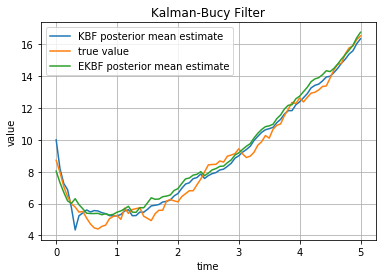

In [7]:
## test:good
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity
T=5
lmax=5
l=4
tau=2**(-l)
N=50
## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    [z,v] = gen_data(T,lmax,collection_input)
    [m,c] = KBF(T,l,lmax,z,collection_input)
    [m1,c1] = EnKBF(T,l,lmax,z,N,collection_input)
v=cut(T,lmax,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
plt.plot(x1,m[:,0],label="KBF posterior mean estimate")
plt.plot(x1,v[:,0],label="true value")
plt.plot(x1,m1[:,0],label="EKBF posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
plt.show()

Coupled Ensemble Kalman Bucy Filter Function

In [8]:
def CEnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**(l-1))
    I=identity(dim).toarray()
    I1=identity(dim_o).toarray()
    dt=2**(-l)
    dt1=2**(-l+1)
    
    m=np.zeros((J*2+1,dim,1))
    m1=np.zeros((J+1,dim,1))
    c=np.zeros((J*2+1,dim,dim))
    c1=np.zeros((J+1,dim,dim))
    z1=cut(T,lmax,l-1,z)
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    x1 = x
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    m1[0]=m[0]
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    c1[0]=c[0]
    
    dw=np.zeros((2,dim,N))
    dv=np.zeros((2,dim_o,N))
    for j in range(J):
        for s in range(2):
            dw[s] = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
            dv[s] = np.random.multivariate_normal(np.zeros(dim_o),dt*I1,N).T
            ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
            ## x-m[j]:dim*N c[j]:dim*dim

            step1=(((x-m[2*j+s]).T)@(H.T))
            step2=step1@(la.inv(R2)@la.inv(R2))
            step3=step2@( (z[2*j+s+1]-z[2*j+s]) - (H@x*dt + R2@dv[s]) )
            step4=(x-m[2*j+s])@step3 /(N-1)

            x = x + A@x*dt + R1@dw[s] + step4
            m[2*j+s+1] = (np.mean(x, axis=1)).reshape(dim,1)
        
        step1=(((x1-m1[j]).T)@(H.T))
        step2=step1@(la.inv(R2)@la.inv(R2))
        step3=step2@( (z1[j+1]-z1[j]) - (H@x1*dt1 + R2@(dv[0]+dv[1])) )
        step4=(x1-m1[j])@step3 /(N-1)
        
        x1 = x1 + A@x1*dt1 + R1@(dw[0]+dw[1]) + step4
        m1[j+1] = (np.mean(x1, axis=1)).reshape(dim,1)
        
    return([m,m1])

Test Floor

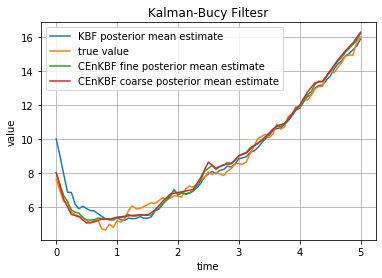

In [10]:
## test:good
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity
T=5
lmax=5
l=4
N=50
tau=2**(-l)
## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    [z,v] = gen_data(T,lmax,collection_input)
    [m,c] = KBF(T,l,lmax,z,collection_input)
    [m2,m3] = CEnKBF(T,l,lmax,z,N,collection_input)
v=cut(T,lmax,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
x2 = 2**(-l+1)*np.arange(T*(2**(l-1))+1)
plt.plot(x1,m[:,0],label="KBF posterior mean estimate")
plt.plot(x1,v[:,0],label="true value")
plt.plot(x1,m2[:,0],label="CEnKBF fine posterior mean estimate")
plt.plot(x2,m3[:,0],label="CEnKBF coarse posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
plt.show()